In [758]:
# framework machine learning yang digunakan
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# tools machine learning untuk mempermudah data pipeline dan image augmentation
from mltu.tensorflow.dataProvider import DataProvider
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness
from mltu.annotations.images import CVImage
from mltu.utils.text_utils import ctc_decoder, get_cer
from mltu.transformers import Transformer
from mltu import Image
from mltu.inferenceModel import OnnxInferenceModel
from mltu.tensorflow.callbacks import Model2onnx
from mltu.augmentors import RandomRotate

# library untuk file manipulation
import os
from zipfile import ZipFile
from datetime import datetime
import logging
import yaml
from dataclasses import dataclass
from pathlib import Path

# library untuk project configuration
from omegaconf import OmegaConf, MISSING
from tqdm import tqdm
from typing import Any, Optional, Union

# library untuk visualisasi, data manipulation, dan membacaa image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preprocessing
##### Tahap ini saya idenya mau membuat label dengan 9 angka urut dari paslon 1, 2, dan 3.
##### Contoh: paslon_1 dapat 98, paslon_2 dapat 167, dan paslon_3 dapat 43,
##### maka labelnya adalah 098167043.
##### Dan juga saya membuat dataset untuk rotate_model untuk klasifikasi biner dengan label 0 dan 1
##### Juga saya mengecualikan gambar-gambar yang ter rotasi untuk kemudahan model dilatih
. \
. \
. 

In [712]:
class DatasetLoader:
    def __init__(self,
               label_csv_path: str,
               train_path: str,
               project_name: str,
               zip_file_path: Optional[str] = None
                ) -> None:
        self.dir = f"Datasets/{project_name}/"
        self.abnormal_image = ['Datasets/gammafest/Train/TPS_015.jpg',
                             'Datasets/gammafest/Train/TPS_069.jpg',
                             'Datasets/gammafest/Train/TPS_085.jpg',
                             'Datasets/gammafest/Train/TPS_108.jpg',
                             'Datasets/gammafest/Train/TPS_207.jpg',
                             'Datasets/gammafest/Train/TPS_222.jpg',
                             'Datasets/gammafest/Train/TPS_270.jpg',
                             'Datasets/gammafest/Train/TPS_422.jpg',
                             'Datasets/gammafest/Train/TPS_430.jpg',
                             'Datasets/gammafest/Train/TPS_468.jpg']
        if zip_file_path is not None:
            self._unzip(zip_file_path, self.dir)
        self.label = self._get_label(self.dir + label_csv_path)
        self.dataset = self._get_dataset(self.dir + train_path)
        self.rotate_label = self._get_rotate_label()
        self.rotate_dataset = self._get_rotate_dataset()

    def _get_label(self, label_csv_path: str) -> pd.DataFrame:
        label = pd.read_csv(label_csv_path)
        merge_label = ["suara_paslon_1", "suara_paslon_2", "suara_paslon_3"]
        self.mean = [label["suara_paslon_1"].mean(), label["suara_paslon_2"].mean(), label["suara_paslon_3"].mean()]
        self.std = [label["suara_paslon_1"].std(), label["suara_paslon_2"].std(), label["suara_paslon_3"].std()]
        for lab in merge_label:
            label[lab] = [str(x) for x in label[lab]]
            label[lab] = ["0" + x if len(x) == 2 else "00" + x if len(x) == 1 else x for x in label[lab]]
        label["label"] = label["suara_paslon_1"] + label["suara_paslon_2"] + label["suara_paslon_3"]
        label: pd.DataFrame = label[["tps", "label"]]
        return label

    def _get_rotate_label(self) -> list[str]:
        label = []
        for x in range(len(self.label) - len(self.abnormal_image)):
            if self.dataset[x][0] in self.abnormal_image:
                # label.append(1)
                continue
            if x % 2 == 0:
                label.append(1)
            else:
                label.append(0)
        return label

    def _get_rotate_dataset(self):
        dataset = []
        for x in range(len(self.rotate_label)):
            dataset.append([self.dataset[x][0], self.rotate_label[x]])
        return dataset

    def _get_dataset(self, train_path: str) -> list[list[str,str]]:
        dataset, vocab, max_len = [], set(), 0
        for x in range(len(self.label)):
            if (train_path + self.label.tps[x] + ".jpg") in self.abnormal_image:
                continue
            image_path = train_path + self.label.tps[x] + ".jpg"
            label = self.label.label[x]
            dataset.append([image_path, label])
            vocab.update(list(label))
            max_len = max(max_len, len(label))
        self.vocab = sorted(vocab)
        self.max_len = max_len
        return dataset

    def _unzip(self, zip_file_path: str, extract_path: str) -> None:
        if not os.path.exists(extract_path):
            zipfile = ZipFile(zip_file_path)
            zipfile.extractall(path=extract_path)
        else:
            return

    def explore(self, model = None) -> None:
        random_int = [np.random.randint(0,len(self.label)) for _ in range(15)]
        fig, axes = plt.subplots(5, 3, figsize=(12, 36))

        for i, ax in enumerate(axes.flat):
            img = cv2.imread(self.dataset[random_int[i]][0])
            ax.imshow(img)
            if model is not None:
                ax.set_title(f"A: {self.dataset[random_int[i]][1]} P: {model.predict(img)}")
            else:
                ax.set_title(self.dataset[random_int[i]][1])
            ax.axis('off')


In [713]:
dataset_loader = DatasetLoader(
    label_csv_path = "label.csv",
    train_path = "Train/",
    project_name = "gammafest",
    zip_file_path = "gammafest24.zip"
)

In [714]:
dataset_loader.dataset

[['Datasets/gammafest/Train/TPS_001.jpg', '159009002'],
 ['Datasets/gammafest/Train/TPS_002.jpg', '112087002'],
 ['Datasets/gammafest/Train/TPS_003.jpg', '173027003'],
 ['Datasets/gammafest/Train/TPS_004.jpg', '207020003'],
 ['Datasets/gammafest/Train/TPS_005.jpg', '213030004'],
 ['Datasets/gammafest/Train/TPS_006.jpg', '201037005'],
 ['Datasets/gammafest/Train/TPS_007.jpg', '159015002'],
 ['Datasets/gammafest/Train/TPS_008.jpg', '120036003'],
 ['Datasets/gammafest/Train/TPS_009.jpg', '186018005'],
 ['Datasets/gammafest/Train/TPS_010.jpg', '056026001'],
 ['Datasets/gammafest/Train/TPS_011.jpg', '071123008'],
 ['Datasets/gammafest/Train/TPS_012.jpg', '075119008'],
 ['Datasets/gammafest/Train/TPS_013.jpg', '024119046'],
 ['Datasets/gammafest/Train/TPS_014.jpg', '027117015'],
 ['Datasets/gammafest/Train/TPS_016.jpg', '097047006'],
 ['Datasets/gammafest/Train/TPS_017.jpg', '065150015'],
 ['Datasets/gammafest/Train/TPS_018.jpg', '048094009'],
 ['Datasets/gammafest/Train/TPS_019.jpg', '04108

In [715]:
dataset_loader.rotate_dataset

[['Datasets/gammafest/Train/TPS_001.jpg', 1],
 ['Datasets/gammafest/Train/TPS_002.jpg', 0],
 ['Datasets/gammafest/Train/TPS_003.jpg', 1],
 ['Datasets/gammafest/Train/TPS_004.jpg', 0],
 ['Datasets/gammafest/Train/TPS_005.jpg', 1],
 ['Datasets/gammafest/Train/TPS_006.jpg', 0],
 ['Datasets/gammafest/Train/TPS_007.jpg', 1],
 ['Datasets/gammafest/Train/TPS_008.jpg', 0],
 ['Datasets/gammafest/Train/TPS_009.jpg', 1],
 ['Datasets/gammafest/Train/TPS_010.jpg', 0],
 ['Datasets/gammafest/Train/TPS_011.jpg', 1],
 ['Datasets/gammafest/Train/TPS_012.jpg', 0],
 ['Datasets/gammafest/Train/TPS_013.jpg', 1],
 ['Datasets/gammafest/Train/TPS_014.jpg', 0],
 ['Datasets/gammafest/Train/TPS_016.jpg', 1],
 ['Datasets/gammafest/Train/TPS_017.jpg', 0],
 ['Datasets/gammafest/Train/TPS_018.jpg', 1],
 ['Datasets/gammafest/Train/TPS_019.jpg', 0],
 ['Datasets/gammafest/Train/TPS_020.jpg', 1],
 ['Datasets/gammafest/Train/TPS_021.jpg', 0],
 ['Datasets/gammafest/Train/TPS_022.jpg', 1],
 ['Datasets/gammafest/Train/TPS_02

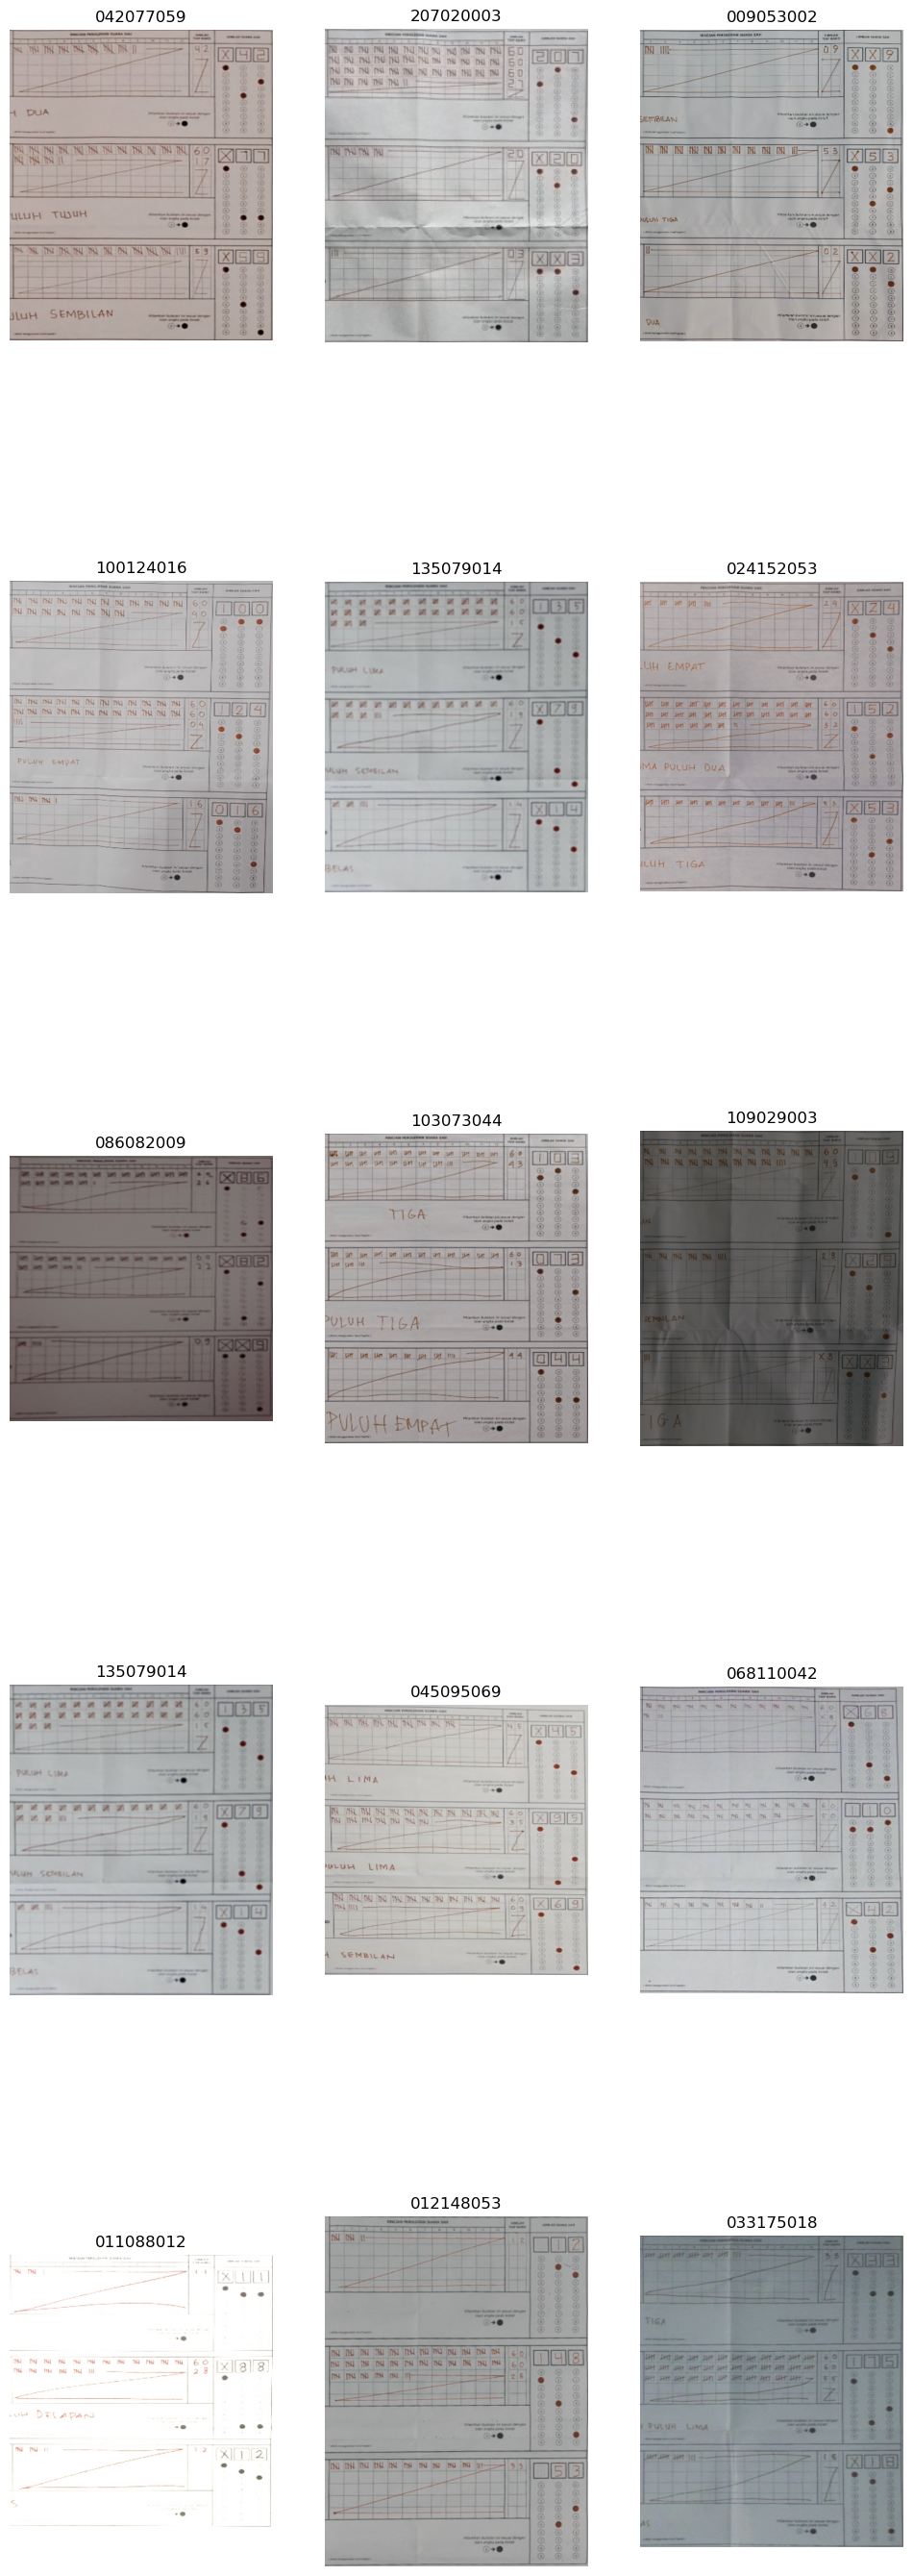

In [716]:
dataset_loader.explore()

## Config
##### Disini saya membuat projek konfigurasi untuk mempermudah eksperimentasi, reproducibility, data versioning, dan model versioning 
. \
. \
.

In [475]:
@dataclass
class ModelConfig:
    model_path: str = MISSING
    vocab: str = MISSING
    height: int = 224
    width: int = 224
    max_text_length: int = MISSING
    batch_size: int = 32
    learning_rate: float = 1e-3
    train_epochs: int = 1000
    train_cer: float = MISSING
    train_wer: float = MISSING
    val_cer: float = MISSING
    val_wer: float = MISSING

In [476]:
def write_config_yaml(path: str, config: ModelConfig) -> None:
    path = Path(path)
    if not path.exists():
        path.parent.mkdir(parents=True, exist_ok=True)
    OmegaConf.save(configs,str(path))

In [477]:
configs = ModelConfig()

configs.vocab = "".join(dataset_loader.vocab)
configs.max_text_length = dataset_loader.max_len

print(OmegaConf.to_yaml(configs))

model_path: ???
vocab: '0123456789'
height: 224
width: 224
max_text_length: 9
batch_size: 32
learning_rate: 0.001
train_epochs: 1000
train_cer: ???
train_wer: ???
val_cer: ???
val_wer: ???



## Transformer
##### Karna data gambar full terlalu noisy untuk gambar ide saya, saya akan memotong sepertiga gambar dan 
##### hanya mengambil sepertiga kanannya untuk mempermudah model mendeteksi dan hanya menyisakan gambar penting yang menentukan
##### Juga saya membuat transformasi rotate untuk rotate dataset sehingga gambar dengan label 1 
##### akan dirotasi 180 derajat karna sebelumnya gambarnya normal
. \
. \
.

In [479]:
class ImageRotate(Transformer):
    def __init__(self):
        pass
    def __call__(self, image: Image, label: Any) -> tuple[Image, Any]:
        if not isinstance(image, Image):
            raise TypeError(f"Expected image to be of type Image, got {type(image)}")
        image_numpy = image.numpy()
        if label == 1:
            image_numpy = cv2.rotate(image_numpy, cv2.ROTATE_180)
        
        image.update(image_numpy)

        return image, label

In [480]:
class ImageCrop(Transformer):
    def __init__(self):
        pass

    def __call__(self, image: Image, label: Any) -> tuple[Image, Any]:
        if not isinstance(image, Image):
            raise TypeError(f"Expected image to be of type Image, got {type(image)}")
        image_numpy = image.numpy()
        height, width = image_numpy.shape[:2]
        crop_width = int(width / 3)
        start_x = width - crop_width
        cropped_image = image_numpy[:, start_x:, :]
        
        image.update(cropped_image)

        return image, label

## Data Provider
##### Disini dimana data gambar dibaca dan ditransformasi sesuai Transformer dan di pecah menjadi data train dan val
. \
. \
.

In [721]:
rotate_data_provider = DataProvider(
    dataset=dataset_loader.rotate_dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageRotate(),
        ImageResizer(configs.width, configs.height)
        ],
)

In [722]:
data_provider = DataProvider(
    dataset=dataset_loader.dataset,
    skip_validation=True,
    batch_size=32,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(configs.width, configs.height),
        ImageCrop(),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab))
        ],
)

In [723]:
rotate_train_data_provider, rotate_val_data_provider = rotate_data_provider.split(split = 0.9)

In [724]:
train_data_provider, val_data_provider = data_provider.split(split = 0.9)

## Loss Function
##### Karna ini tasknya image-to-text saya menggunakan CTCLoss untuk menghitung loss function
. \
. \
.

In [419]:
# tf.keras.utils.get_custom_objects().clear()

In [759]:
# @keras.utils.generic_utils.register_keras_serializable(package="CTCLoss")
class CTCloss(tf.keras.losses.Loss):
    def __init__(self, name: str = "CTCloss", reduction: str = "auto") -> None:
        super(CTCloss, self).__init__()
        self.name = name
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None) -> tf.Tensor:
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int32")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int32")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int32")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int32")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int32")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)

        return loss
    
    def get_config(self):
        config = super(CTCloss, self).get_config()
        return config

## Metrics
##### Metrik yang digunakan adalah Character Error Rate (CER) dan Word Error Rate (WER)
. \
. \
.

In [760]:
# @keras.utils.generic_utils.register_keras_serializable(package="CWERMetric")
class CWERMetric(tf.keras.metrics.Metric):
    def __init__(self, padding_token, name="CWER", **kwargs) -> None:
        super(CWERMetric, self).__init__(name=name, **kwargs)

        self.cer_accumulator = tf.Variable(0.0, name="cer_accumulator", dtype=tf.float32)
        self.wer_accumulator = tf.Variable(0.0, name="wer_accumulator", dtype=tf.float32)
        self.batch_counter = tf.Variable(0, name="batch_counter", dtype=tf.int32)

        self.padding_token = padding_token

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None) -> None:
        input_shape = tf.keras.backend.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0], dtype="int32") * tf.cast(input_shape[1], "int32")
        
        y_true = tf.cast(y_true, dtype=tf.int32)

        decode_predicted, log = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=True)

        predicted_labels_sparse = tf.keras.backend.ctc_label_dense_to_sparse(decode_predicted[0], input_length)
        true_labels_sparse = tf.cast(tf.keras.backend.ctc_label_dense_to_sparse(y_true, input_length), "int64")

        predicted_labels_sparse = tf.sparse.retain(predicted_labels_sparse, tf.not_equal(predicted_labels_sparse.values, -1))
        true_labels_sparse = tf.sparse.retain(true_labels_sparse, tf.not_equal(true_labels_sparse.values, self.padding_token))

        distance = tf.edit_distance(predicted_labels_sparse, true_labels_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.batch_counter.assign_add(input_shape[0])
        self.wer_accumulator.assign_add(tf.reduce_sum(tf.cast(tf.not_equal(distance, 0), tf.float32)))

    def result(self) -> dict[str, tf.Tensor]:
        return {
                "CER": tf.math.divide_no_nan(self.cer_accumulator, tf.cast(self.batch_counter, tf.float32)),
                "WER": tf.math.divide_no_nan(self.wer_accumulator, tf.cast(self.batch_counter, tf.float32))
        }
    
    def get_config(self) -> dict:
        config = {"padding_token": self.padding_token}
        base_config = super(CWERMetric, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Logger
##### Ini adalah custom callback logger untuk menulis semua output yang dikeluarkan waktu training model sehingga mempermudah tracing
. \
. \
.

In [761]:
class TrainLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_path: str, log_file: str="logs.log", logLevel=logging.INFO, console_output=False) -> None:
        super().__init__()
        self.log_path = log_path
        self.log_file = log_file

        if not os.path.exists(log_path):
            os.mkdir(log_path)

        self.logger = logging.getLogger()
        self.logger.setLevel(logLevel)

        self.formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

        self.file_handler = logging.FileHandler(os.path.join(self.log_path, self.log_file))
        self.file_handler.setLevel(logLevel)
        self.file_handler.setFormatter(self.formatter)

        if not console_output:
            self.logger.handlers[:] = []

        self.logger.addHandler(self.file_handler)

    def on_epoch_end(self, epoch: int, logs: dict=None) -> None:
        epoch_message = f"Epoch {epoch}; "
        logs_message = "; ".join([f"{key}: {value}" for key, value in logs.items()])
        self.logger.info(epoch_message + logs_message)

## Model
##### Ide saya adalah menggunakan arsitektur Resnet dengan residual_block pada Convolution 2D dan Convolution 1D 
##### sehingga hidden state pada layer sebelumnya tidak menghilang di layer lanjut
##### Untuk activation saya menggunakan LeakyRelu untuk menghindari dead kernel dan 
##### ekstraksi fitur pada vektor negatif yang tidak bisa dilakukan Relu biasa
##### Saya juga membuat rotate_model dengan residual block juga hanya untuk mendeteksi apakah suatu gambar ter rotasi atau tidak
##### Nanti saat prediksi gambar awal akan dimasukkan ke rotate model dulu untuk dicek status rotasinya, 
##### jika iya akan dirotasi jika tidak akan dibiarkan dan baru akan dimasukkan ke model asli
. \
. \
.

In [762]:
def activation_layer(input: tf.Tensor, activation: str="relu", alpha: float=0.1) -> tf.Tensor:
    if activation == "relu":
        input = layers.ReLU()(input)
    elif activation == "leaky_relu":
        input = layers.LeakyReLU(alpha=alpha)(input)

    return input

In [763]:
def residual_block(
        x: tf.Tensor,
        filter_num: int,
        strides: int = 2,
        kernel_size: int = 3,
        skip_conv: bool = True,
        padding: str = "same",
        activation: str = "relu",
        dropout: float = 0.2) -> tf.Tensor:
    x_skip = x

    x = layers.Conv2D(filter_num, kernel_size, padding = padding, strides = strides)(x)
    x = layers.BatchNormalization()(x)
    x = activation_layer(x, activation=activation)

    x = layers.Conv2D(filter_num, kernel_size, padding = padding)(x)
    x = layers.BatchNormalization()(x)

    if skip_conv:
        x_skip = layers.Conv2D(filter_num, 1, padding = padding, strides = strides)(x_skip)

    x = layers.Add()([x, x_skip])
    x = activation_layer(x, activation=activation)

    if dropout:
        x = layers.Dropout(dropout)(x)

    return x

In [764]:
def residual_block_conv1d(inputs, filters, kernel_size = 3, strides=1, padding="same", activation = "relu", dropout = 0.2):
    shortcut = inputs
    
    x = layers.Conv1D(filters, kernel_size, strides=strides, padding=padding)(inputs)
    x = layers.BatchNormalization()(x)
    x = activation_layer(x, activation=activation)
    
    x = layers.Conv1D(filters, kernel_size, strides=1, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    
    if strides != 1 or padding != "same":
        shortcut = layers.Conv1D(filters, kernel_size, strides=strides, padding=padding)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x += shortcut
    x = activation_layer(x, activation=activation)
    
    if dropout:
        x = layers.Dropout(dropout)(x)
    
    return x

In [765]:
def train_model(input_dim, output_dim, activation="leaky_relu", dropout=0.2) -> tf.keras.Model:

    inputs = layers.Input(shape=input_dim, name="input")

    x = layers.Lambda(lambda x: x / 255)(inputs)

    x = residual_block(x, 16, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x = residual_block(x, 16, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 16, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x = residual_block(x, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x = residual_block(x, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 32, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x = residual_block(x, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x = layers.Reshape((x.shape[-3] * x.shape[-2], x.shape[-1]))(x)

    x = residual_block_conv1d(x, 64, activation=activation, strides=2, dropout=dropout)
    x = residual_block_conv1d(x, 64, activation=activation, strides=1, dropout=dropout)
    
    x = residual_block_conv1d(x, 64, activation=activation, strides=2, dropout=dropout)
    x = residual_block_conv1d(x, 64, activation=activation, strides=1, dropout=dropout)

    output = layers.Dense(output_dim + 1, activation="softmax", name="output")(x)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

In [768]:
def load_rotate_model():
    inputs = layers.Input(shape=(configs.height, configs.width, 3), name="input")

    x = layers.Lambda(lambda x: x / 255)(inputs)

    x = residual_block(x, 16, activation="relu", skip_conv=True, strides=1, dropout=0)

    x = residual_block(x, 16, activation="relu", skip_conv=True, strides=2, dropout=0)
    x = residual_block(x, 16, activation="relu", skip_conv=False, strides=1, dropout=0)

    x = layers.GlobalAvgPool2D()(x)

    output = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model

## Training
##### Disini saya melakukan training untuk model dan rotate_model
. \
. \
.

In [769]:
rotate_model = load_rotate_model()

In [770]:
model = train_model(
    input_dim = (configs.height, int(configs.width/3), 3),
    output_dim = len(configs.vocab),
)

In [771]:
rotate_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
    metrics = ["accuracy"]
)
rotate_model.summary()

Model: "model_62"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda_5 (Lambda)           (None, 224, 224, 3)          0         ['input[0][0]']               
                                                                                                  
 conv2d_120 (Conv2D)         (None, 224, 224, 16)         448       ['lambda_5[0][0]']            
                                                                                                  
 batch_normalization_140 (B  (None, 224, 224, 16)         64        ['conv2d_120[0][0]']          
 atchNormalization)                                                                        

In [773]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
    loss=CTCloss(),
    metrics=[CWERMetric(len(configs.vocab))]
)
model.summary(line_length=110)

Model: "model_63"
______________________________________________________________________________________________________________
 Layer (type)                    Output Shape                     Param #    Connected to                     
 input (InputLayer)              [(None, 224, 74, 3)]             0          []                               
                                                                                                              
 lambda_6 (Lambda)               (None, 224, 74, 3)               0          ['input[0][0]']                  
                                                                                                              
 conv2d_128 (Conv2D)             (None, 224, 74, 16)              448        ['lambda_6[0][0]']               
                                                                                                              
 batch_normalization_146 (Batch  (None, 224, 74, 16)              64         ['conv2d_128[0][0

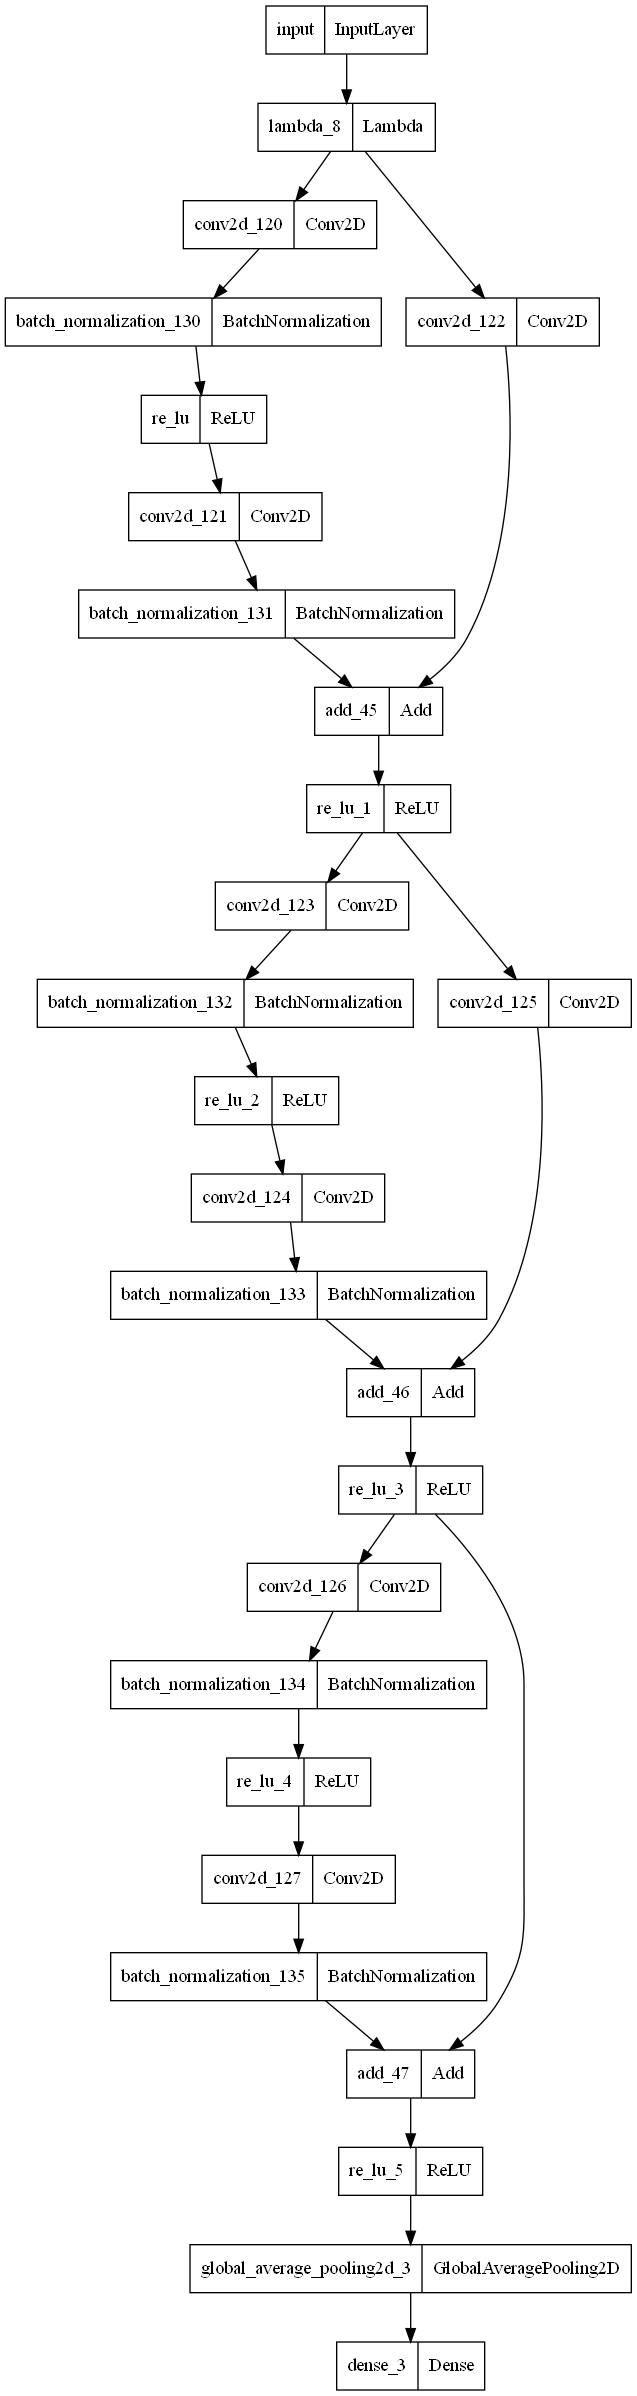

In [733]:
tf.keras.utils.plot_model(rotate_model)

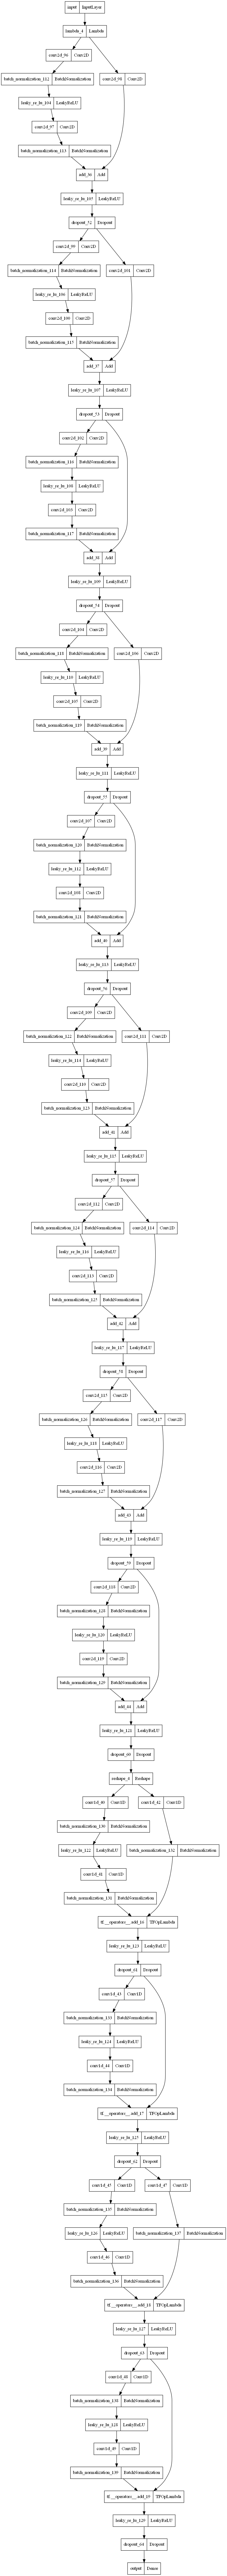

In [441]:
tf.keras.utils.plot_model(model)

In [486]:
configs.model_path = os.path.join("Models/gammafest", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))

os.makedirs(configs.model_path, exist_ok=True)

In [487]:
# callback untuk rotate_model
rotate_earlystopper = EarlyStopping(monitor="val_accuracy", patience=30, verbose=1, mode="max")
rotate_reduceLROnPlat = ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, min_delta=1e-10, patience=20, verbose=1, mode="max")
rotate_checkpoint = ModelCheckpoint(f"{configs.model_path}/rotate_model.h5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

In [649]:
# callback untuk model
earlystopper = EarlyStopping(monitor="val_CER", patience=50, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=20, verbose=1, mode="min")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

In [577]:
rotate_history = rotate_model.fit(
    rotate_train_data_provider,
    validation_data=rotate_val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[rotate_earlystopper, rotate_checkpoint, rotate_reduceLROnPlat]
)

In [462]:
# model.load_weights("Models/gammafest/202404211826/model.h5") #hanya untuk melanjutkan training model yang terbaik

In [734]:
# Untuk training hal pertama saya melakukan training dengan train_provider, baru langkah kedua menggunakan full data_provider

In [653]:
history = model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx]
)

Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0319 - CER: 0.0000e+00 - WER: 0.0000e+00
Epoch 1: val_CER did not improve from 0.00000
1/1 [==============================] - 1s 1s/step - loss: 0.0319 - CER: 0.0000e+00 - WER: 0.0000e+00 - val_loss: 9.7028e-04 - val_CER: 0.0000e+00 - val_WER: 0.0000e+00 - lr: 3.1381e-04
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6364 - CER: 0.1111 - WER: 1.0000
Epoch 2: val_CER did not improve from 0.00000
1/1 [==============================] - 0s 239ms/step - loss: 3.6364 - CER: 0.1111 - WER: 1.0000 - val_loss: 0.0015 - val_CER: 0.0000e+00 - val_WER: 0.0000e+00 - lr: 3.1381e-04
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0026 - CER: 0.0000e+00 - WER: 0.0000e+00
Epoch 3: val_CER did not improve from 0.00000
1/1 [==============================] - 0s 250ms/step - loss: 0.0026 - CER: 0.0000e+00 - WER: 0.0000e+00 - val_loss: 0.0041 - val_CER: 0.0000e+00 - val_WER: 0.0000e+00 - lr: 3.1381e-04
E

In [600]:
# simpan konfigurasi ke file
configs.train_cer = min(history.history["CER"])
configs.train_wer = min(history.history["WER"])
configs.val_cer = min(history.history["val_CER"])
configs.val_wer = min(history.history["val_WER"])

yaml_file_path = os.path.join(configs.model_path, "configs.yaml")
write_config_yaml(yaml_file_path, configs)
print(OmegaConf.to_yaml(configs))

model_path: Models/gammafest\202404220805
vocab: '0123456789'
height: 224
width: 224
max_text_length: 9
batch_size: 48
learning_rate: 0.001
train_epochs: 1000
train_cer: 0.001459853956475854
train_wer: 0.013138686306774616
val_cer: 0.0
val_wer: 0.0



## Plotting
##### Visualisasi hasil training model
. \
. \
. 

In [495]:
def plot_training_history(history, variables):
    for variable in variables:
        plt.plot(history.history[variable], label=variable)

    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

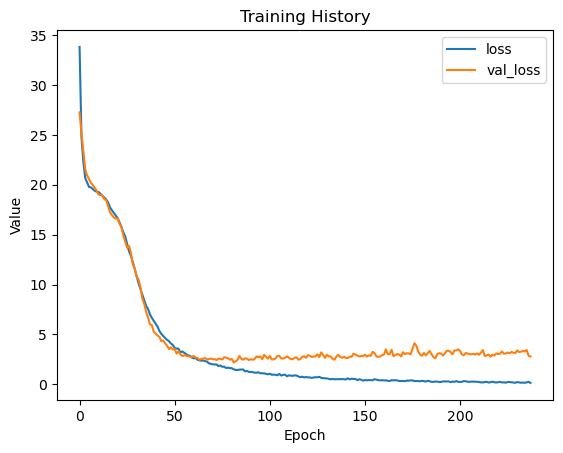

In [222]:
plot_training_history(history,["loss", "val_loss"])

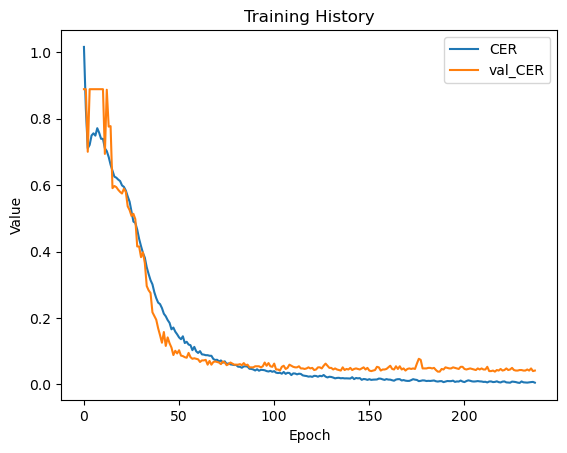

In [223]:
plot_training_history(history,["CER", "val_CER"])

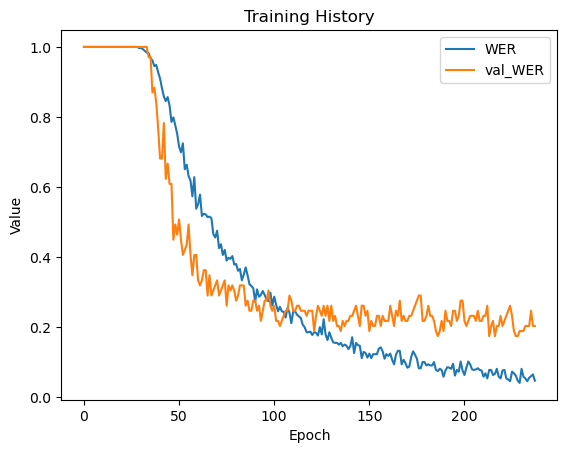

In [224]:
plot_training_history(history,["WER", "val_WER"])

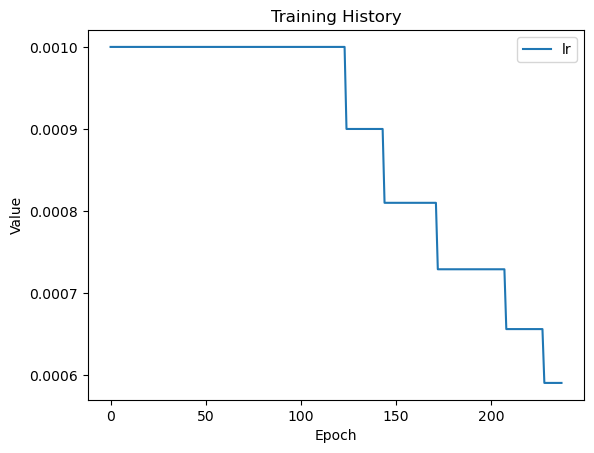

In [225]:
plot_training_history(history,["lr"])

## Load Model
##### Karena saya menggunakan custom loss dan custom metric saya ga bisa melakukan load model, hanya bisa load weight, 
##### sehingga alternatifnya saya menyimpannya juga dalam format onnx
. \
. \
.

In [559]:
# model.load_weights(full_path + "model.h5")

In [727]:
# simpan data yang sudah dibersihkan ke file model_path
train_data_provider.to_csv(os.path.join(configs.model_path, "train.csv"))
val_data_provider.to_csv(os.path.join(configs.model_path, "val.csv"))
data_provider.to_csv(os.path.join(configs.model_path, "full.csv"))

In [728]:
# Disini saya menggabungkan 2 model yaitu model dan rotate_model sehingga gambar pertama akan dideteksi apakah dia terotasi 
# kalau iya akan dirotasi kalau tidak akan dibiarkan dan selanjutnya gambar tersebut dimasukkan ke model sebenarnya
class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list: Union[str, list], rotate_model = None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list
        self.rotate_model = rotate_model

    def predict(self, image: np.ndarray):
        image = cv2.resize(image, (configs.width, configs.height))

        if self.rotate_model is not None:
            image_rot = np.expand_dims(image, axis=0).astype(np.float32)
            rot = self.rotate_model(image_rot)
            if rot > 0.7:
                image = cv2.rotate(image, cv2.ROTATE_180)
        
        height, width = image.shape[:2]
        crop_width = int(width / 3)
        start_x = width - crop_width
        image = image[:, start_x:, :]
        
        image = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(self.output_names, {self.input_names[0]: image})[0]

        text = ctc_decoder(preds, self.char_list)[0]

        return text

In [730]:
# load model, konfigurasi, dan data pada file dan melakukan prediksi pada val dataset
latest_path = sorted(os.listdir("Models/gammafest/"))[-1]
full_path = f"Models/gammafest/{latest_path}/"
configs = OmegaConf.load(full_path + "configs.yaml")

rotate_model = tf.keras.models.load_model("Rotate_Model/rotate_model.h5")
model_onnx = ImageToWordModel(model_path=configs.model_path, char_list=configs.vocab, rotate_model=rotate_model)

df = pd.read_csv(full_path + "val.csv")
df["1"] = ["0"*(9-len(str(x))) + str(x) for x in df["1"]]
df = df.values.tolist()

accum_cer = []
for image_path, label in tqdm(df):
    image = cv2.imread(image_path.replace("\\", "/"))

    prediction_text = model_onnx.predict(image)

    cer = get_cer(prediction_text, label)
    print(f"Image: {image_path}, Label: {label}, Prediction: {prediction_text}, CER: {cer}")

    accum_cer.append(cer)

print(f"Average CER: {np.average(accum_cer)}")

  4%|███▍                                                                               | 2/49 [00:00<00:05,  7.91it/s]

Image: Datasets/gammafest/Train/TPS_074.jpg, Label: 011116022, Prediction: 011116022, CER: 0.0
Image: Datasets/gammafest/Train/TPS_247.jpg, Label: 101111028, Prediction: 101111028, CER: 0.0
Image: Datasets/gammafest/Train/TPS_401.jpg, Label: 020119101, Prediction: 020119101, CER: 0.0


 12%|██████████▏                                                                        | 6/49 [00:00<00:04, 10.46it/s]

Image: Datasets/gammafest/Train/TPS_158.jpg, Label: 056167017, Prediction: 056167017, CER: 0.0
Image: Datasets/gammafest/Train/TPS_096.jpg, Label: 014201035, Prediction: 014201035, CER: 0.0
Image: Datasets/gammafest/Train/TPS_185.jpg, Label: 033117046, Prediction: 033117046, CER: 0.0


 16%|█████████████▌                                                                     | 8/49 [00:00<00:03, 10.69it/s]

Image: Datasets/gammafest/Train/TPS_124.jpg, Label: 095070025, Prediction: 095070025, CER: 0.0
Image: Datasets/gammafest/Train/TPS_106.jpg, Label: 085165011, Prediction: 085165011, CER: 0.0
Image: Datasets/gammafest/Train/TPS_448.jpg, Label: 013104118, Prediction: 013104118, CER: 0.0


 24%|████████████████████                                                              | 12/49 [00:01<00:03, 10.09it/s]

Image: Datasets/gammafest/Train/TPS_474.jpg, Label: 018157040, Prediction: 018157040, CER: 0.0
Image: Datasets/gammafest/Train/TPS_496.jpg, Label: 011150060, Prediction: 011150060, CER: 0.0
Image: Datasets/gammafest/Train/TPS_151.jpg, Label: 096082014, Prediction: 096082014, CER: 0.0


 31%|█████████████████████████                                                         | 15/49 [00:01<00:03,  9.58it/s]

Image: Datasets/gammafest/Train/TPS_315.jpg, Label: 012052041, Prediction: 012052041, CER: 0.0
Image: Datasets/gammafest/Train/TPS_299.jpg, Label: 031111056, Prediction: 031111056, CER: 0.0
Image: Datasets/gammafest/Train/TPS_008.jpg, Label: 120036003, Prediction: 120036003, CER: 0.0


 35%|████████████████████████████▍                                                     | 17/49 [00:01<00:03,  8.73it/s]

Image: Datasets/gammafest/Train/TPS_475.jpg, Label: 022137060, Prediction: 022137060, CER: 0.0
Image: Datasets/gammafest/Train/TPS_357.jpg, Label: 045095069, Prediction: 045095069, CER: 0.0


 39%|███████████████████████████████▊                                                  | 19/49 [00:02<00:03,  8.02it/s]

Image: Datasets/gammafest/Train/TPS_041.jpg, Label: 094044001, Prediction: 094044001, CER: 0.0
Image: Datasets/gammafest/Train/TPS_256.jpg, Label: 075107039, Prediction: 075107039, CER: 0.0
Image: Datasets/gammafest/Train/TPS_231.jpg, Label: 011118059, Prediction: 011118059, CER: 0.0


 47%|██████████████████████████████████████▍                                           | 23/49 [00:02<00:02,  9.61it/s]

Image: Datasets/gammafest/Train/TPS_079.jpg, Label: 064145016, Prediction: 064145016, CER: 0.0
Image: Datasets/gammafest/Train/TPS_279.jpg, Label: 009069097, Prediction: 009069097, CER: 0.0
Image: Datasets/gammafest/Train/TPS_326.jpg, Label: 021111112, Prediction: 021111112, CER: 0.0


 51%|█████████████████████████████████████████▊                                        | 25/49 [00:02<00:02,  9.58it/s]

Image: Datasets/gammafest/Train/TPS_328.jpg, Label: 052094095, Prediction: 052094095, CER: 0.0
Image: Datasets/gammafest/Train/TPS_409.jpg, Label: 056105054, Prediction: 056105054, CER: 0.0


 55%|█████████████████████████████████████████████▏                                    | 27/49 [00:02<00:02,  9.02it/s]

Image: Datasets/gammafest/Train/TPS_059.jpg, Label: 072169012, Prediction: 072169012, CER: 0.0
Image: Datasets/gammafest/Train/TPS_208.jpg, Label: 125061008, Prediction: 125061008, CER: 0.0
Image: Datasets/gammafest/Train/TPS_123.jpg, Label: 133063018, Prediction: 133063018, CER: 0.0


 61%|██████████████████████████████████████████████████▏                               | 30/49 [00:03<00:02,  9.10it/s]

Image: Datasets/gammafest/Train/TPS_267.jpg, Label: 105113019, Prediction: 105113019, CER: 0.0
Image: Datasets/gammafest/Train/TPS_264.jpg, Label: 064131004, Prediction: 064131004, CER: 0.0
Image: Datasets/gammafest/Train/TPS_062.jpg, Label: 068147030, Prediction: 068147030, CER: 0.0


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [00:03<00:01,  9.28it/s]

Image: Datasets/gammafest/Train/TPS_480.jpg, Label: 016156032, Prediction: 016156032, CER: 0.0
Image: Datasets/gammafest/Train/TPS_403.jpg, Label: 010129061, Prediction: 010129061, CER: 0.0


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [00:03<00:01,  8.89it/s]

Image: Datasets/gammafest/Train/TPS_405.jpg, Label: 005078122, Prediction: 005078122, CER: 0.0
Image: Datasets/gammafest/Train/TPS_276.jpg, Label: 013060076, Prediction: 013060076, CER: 0.0


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [00:04<00:01,  8.89it/s]

Image: Datasets/gammafest/Train/TPS_449.jpg, Label: 011055117, Prediction: 011055117, CER: 0.0
Image: Datasets/gammafest/Train/TPS_051.jpg, Label: 072048001, Prediction: 072048001, CER: 0.0
Image: Datasets/gammafest/Train/TPS_450.jpg, Label: 032162067, Prediction: 032162067, CER: 0.0


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [00:04<00:00,  9.37it/s]

Image: Datasets/gammafest/Train/TPS_274.jpg, Label: 122083008, Prediction: 122083008, CER: 0.0
Image: Datasets/gammafest/Train/TPS_217.jpg, Label: 068110042, Prediction: 068110042, CER: 0.0


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [00:04<00:00,  8.81it/s]

Image: Datasets/gammafest/Train/TPS_426.jpg, Label: 031101050, Prediction: 031101050, CER: 0.0
Image: Datasets/gammafest/Train/TPS_237.jpg, Label: 023187016, Prediction: 023187016, CER: 0.0


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [00:04<00:00,  9.31it/s]

Image: Datasets/gammafest/Train/TPS_134.jpg, Label: 041119057, Prediction: 041119057, CER: 0.0
Image: Datasets/gammafest/Train/TPS_375.jpg, Label: 011110055, Prediction: 011110055, CER: 0.0
Image: Datasets/gammafest/Train/TPS_295.jpg, Label: 023096103, Prediction: 023096103, CER: 0.0


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [00:05<00:00,  9.72it/s]

Image: Datasets/gammafest/Train/TPS_318.jpg, Label: 055122007, Prediction: 055122007, CER: 0.0
Image: Datasets/gammafest/Train/TPS_457.jpg, Label: 121097013, Prediction: 121097013, CER: 0.0
Image: Datasets/gammafest/Train/TPS_178.jpg, Label: 059088002, Prediction: 059088002, CER: 0.0


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:05<00:00,  9.23it/s]

Image: Datasets/gammafest/Train/TPS_032.jpg, Label: 070044006, Prediction: 070044006, CER: 0.0
Average CER: 0.0


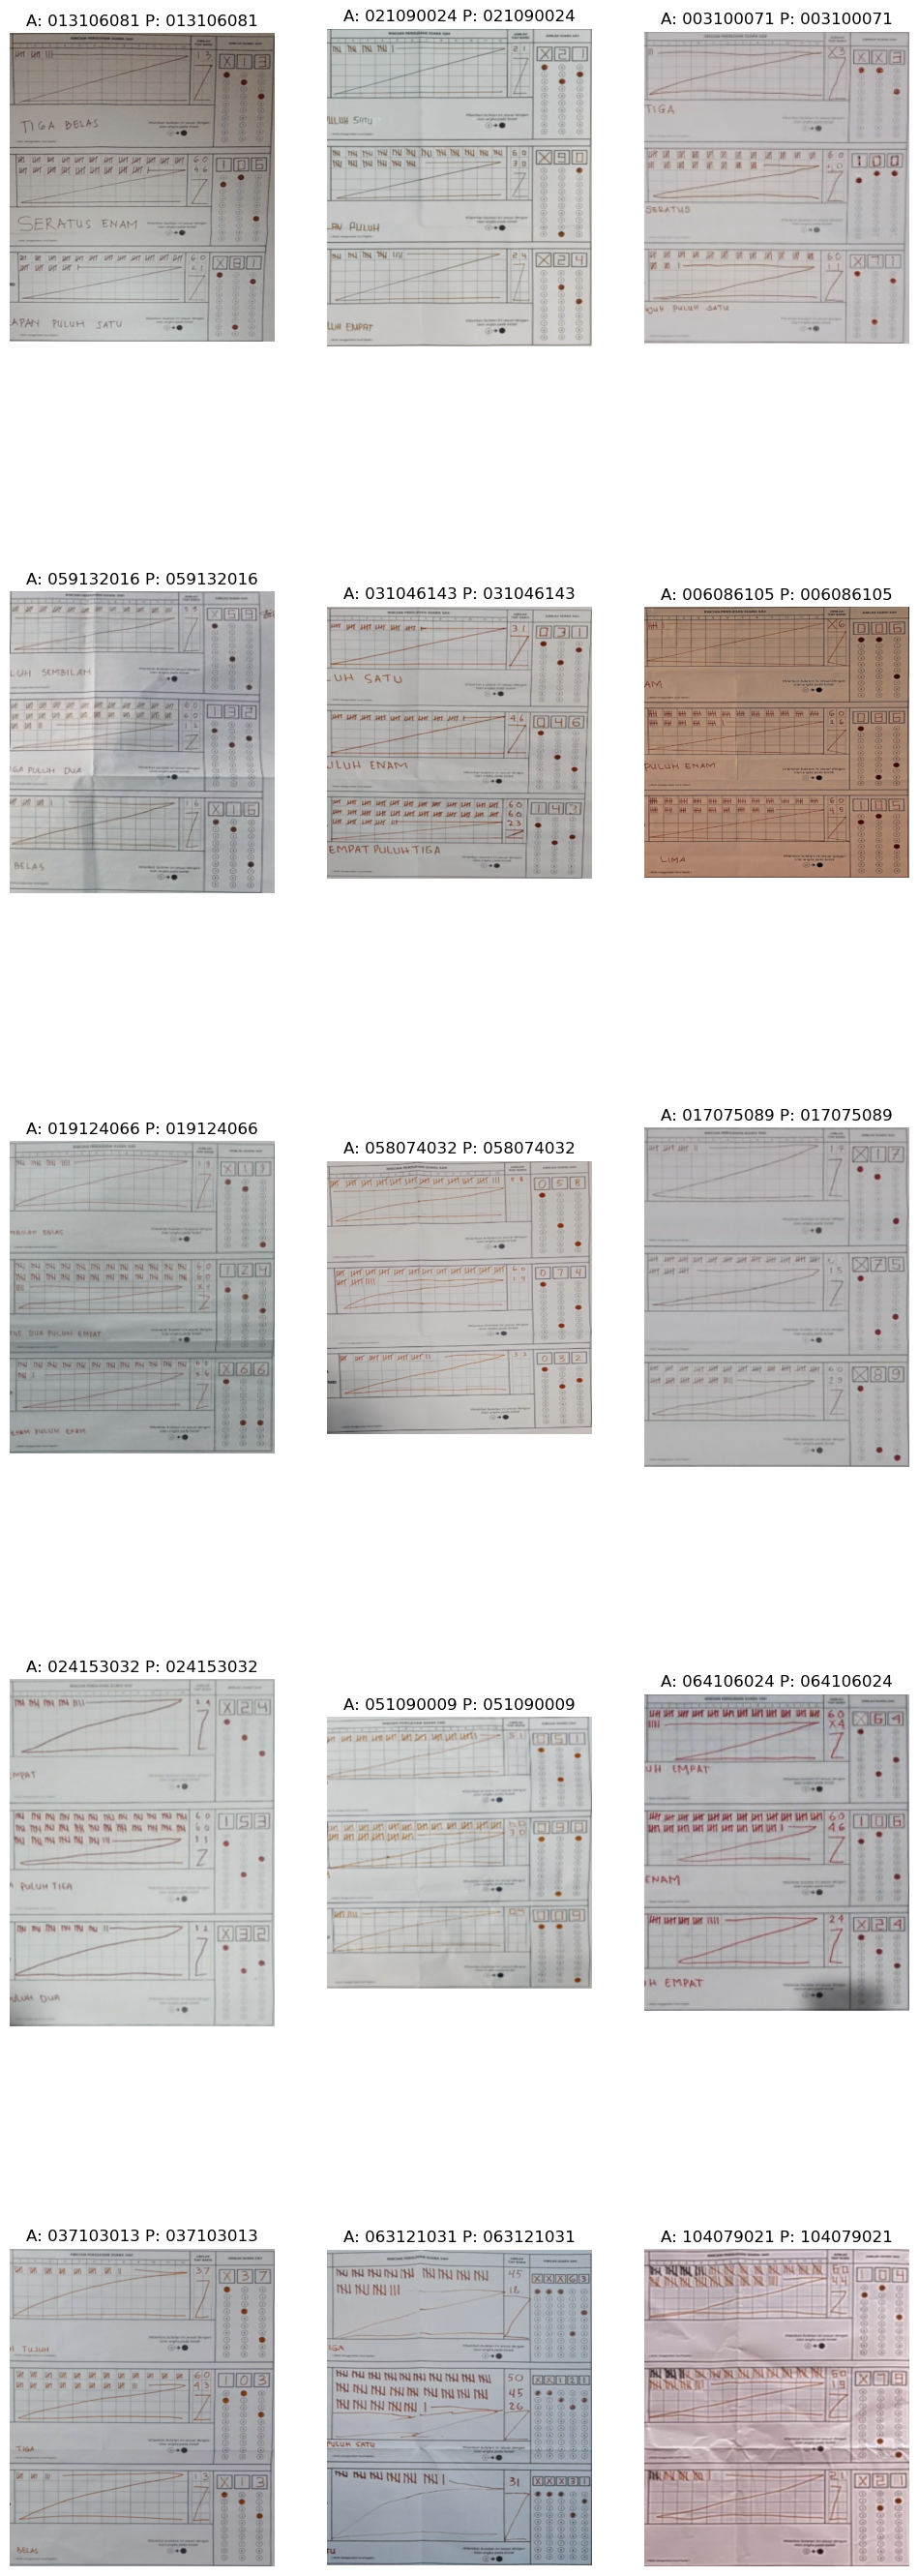

In [499]:
dataset_loader.explore(model_onnx)

## Grad-Cam
##### Saya menggunakan gradcam untuk memahami apa fitur dari gambar yang digunakan untuk memprediksi label
##### dan juga memahami apa yang salah di prediksi
. \
. \
.

In [500]:
def build_model():
    return 

In [501]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (configs.width, configs.height))
    height, width = img.shape[:2]
    crop_width = int(width / 3)
    start_x = width - crop_width
    img = img[:, start_x:, :]
    img = np.expand_dims(img, axis=0)
    return img

In [502]:
def grad_cam(model, img,
             layer_name="conv2d_1", 
             label_name=None,
             category_id=None):

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])
    
    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img)
        if category_id is None:
            category_id = np.argmax(predictions, axis=-1)
        indices = [[0,x,category_id[0,x]] for x in range(14)]
        output = tf.gather_nd(predictions, indices)
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap)

In [503]:
def grad_cam_plus(model, img,
                  layer_name="conv2d_1",
                  category_id=None):
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id is None:
                    category_id = np.argmax(predictions, axis=-1)
                indices = [[0,x,category_id[0,x]] for x in range(14)]
                output = tf.gather_nd(predictions, indices)
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_cam_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap

In [504]:
def grad_cam_visualize(model, list_img_path, layer_name='conv2d_1', grad_type: str = "gradcam"):
    if len(list_img_path) != 3:
        raise ValueError("Just need 3 image path")
        
    plt.figure(figsize=(12, 12))
    for x in range(3):
        preprocessed_input = load_image(img_path[x])
        predictions = model.predict(preprocessed_input)
        
        classes = ctc_decoder(predictions, configs.vocab)[0]
        if grad_type == "gradcam":
            gradcam = grad_cam(model, preprocessed_input, layer_name)
        elif grad_type == "gradcam_plus":
            gradcam = grad_cam(model, preprocessed_input, layer_name)
        
        plt.subplot(1,3,x+1)
        plt.title(classes)
        plt.axis('off')
        plt.imshow(load_image(img_path[x])[0])
        plt.imshow(gradcam, cmap='jet', alpha=0.5)
        plt.savefig("gradcam.png")
        


1/1 [==============================] - 0s 46ms/step


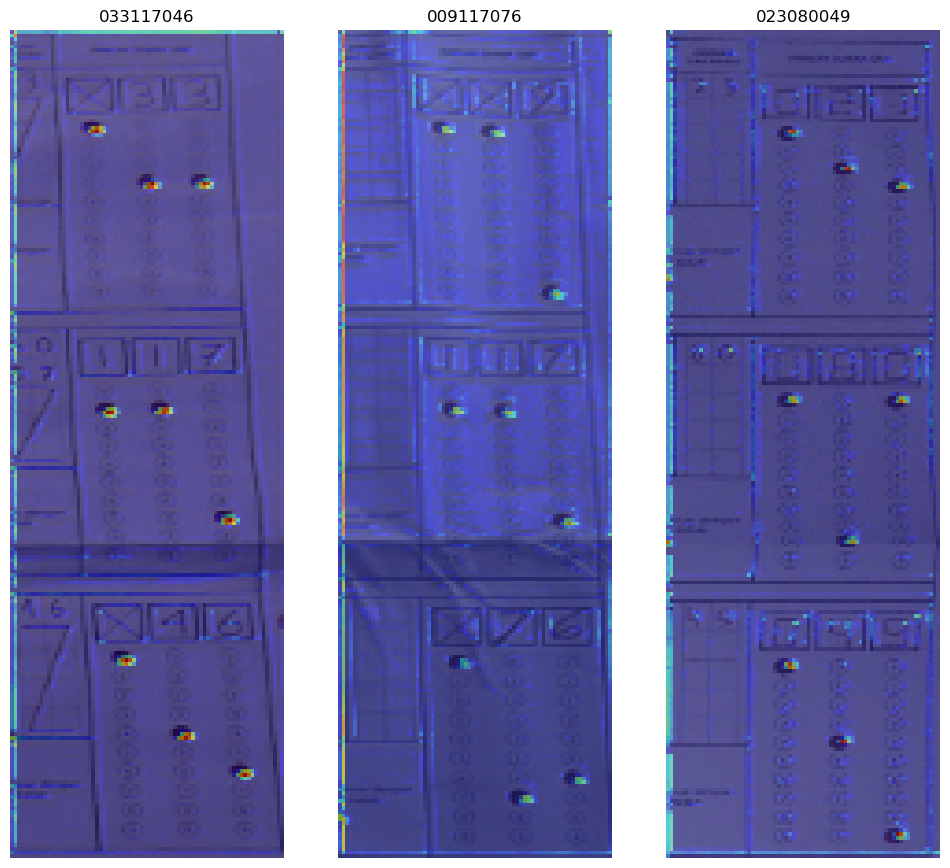

In [740]:
img_path = [dataset_loader.dataset[np.random.randint(0, len(dataset_loader.dataset))][0] for _ in range(3)]
grad_cam_visualize(model, img_path, layer_name=model.layers[10].name, grad_type = "gradcam")

1/1 [==============================] - 0s 40ms/step


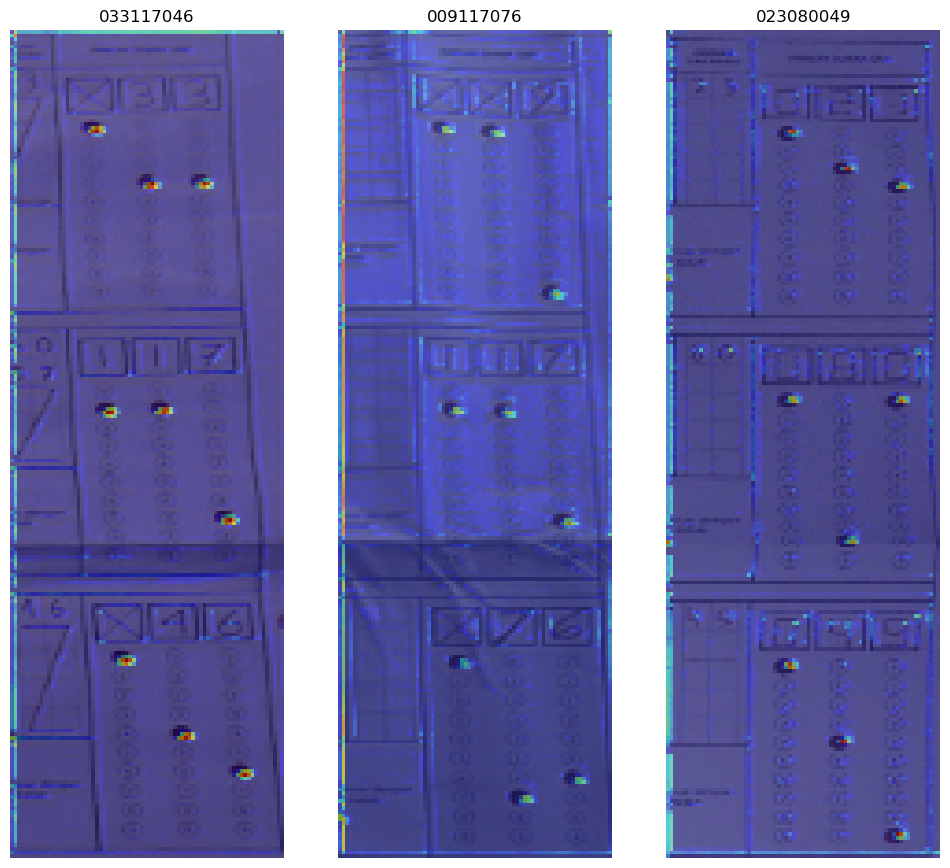

In [741]:
grad_cam_visualize(model, img_path, layer_name=model.layers[10].name, grad_type = "gradcam_plus")

## Submit
##### Setelah dirasa model sudah cukup bagus disini saya melakukan deteksi pada data test untuk selanjutnya disubmit
. \
. \
.

In [744]:
list_submit_image = os.listdir("Datasets/gammafest/Test/")

In [745]:
pred_text = []
for image_path in tqdm(list_submit_image):
  image = cv2.imread("Datasets/gammafest/Test/" + image_path)
  prediction_text = model_onnx.predict(image)

  pred_text.append(prediction_text)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.95it/s]


In [746]:
pred_text

['077141018',
 '125098012',
 '041165023',
 '021153041',
 '059172011',
 '068120031',
 '040170047',
 '047126038',
 '048158032',
 '040167010',
 '010163048',
 '054172027',
 '029202008',
 '029161050',
 '070071039',
 '073077034',
 '022183045',
 '046154032',
 '034109049',
 '019170053',
 '014143049',
 '047149034',
 '030137041',
 '026157058',
 '008166030',
 '010176060',
 '011162071',
 '008104045',
 '010141043',
 '009148041',
 '025155034',
 '009149018',
 '014158067',
 '045131022',
 '018153033',
 '017160057',
 '052121028',
 '024158048',
 '016114030',
 '018140039',
 '022165017',
 '029160016',
 '040083008',
 '022167023',
 '032147028',
 '019171057',
 '012174035',
 '008154044',
 '039167037',
 '026141051',
 '010144030',
 '020123041',
 '018188021',
 '036211022',
 '021200020',
 '010159049',
 '024162027',
 '227021001',
 '078157014',
 '069079017',
 '074147013',
 '093071058',
 '013206041',
 '032160053',
 '033147058',
 '027103031',
 '031042097',
 '061075079',
 '016081054',
 '052139027',
 '043096034',
 '0460

In [747]:
# Ini memotong prediksi yang lebih dari 9 panjangnya, walaupun sekarang sudah tidak berguna
clean_pred = [x[:9] if len(x) > 9 else x for x in pred_text]
clean_pred

['077141018',
 '125098012',
 '041165023',
 '021153041',
 '059172011',
 '068120031',
 '040170047',
 '047126038',
 '048158032',
 '040167010',
 '010163048',
 '054172027',
 '029202008',
 '029161050',
 '070071039',
 '073077034',
 '022183045',
 '046154032',
 '034109049',
 '019170053',
 '014143049',
 '047149034',
 '030137041',
 '026157058',
 '008166030',
 '010176060',
 '011162071',
 '008104045',
 '010141043',
 '009148041',
 '025155034',
 '009149018',
 '014158067',
 '045131022',
 '018153033',
 '017160057',
 '052121028',
 '024158048',
 '016114030',
 '018140039',
 '022165017',
 '029160016',
 '040083008',
 '022167023',
 '032147028',
 '019171057',
 '012174035',
 '008154044',
 '039167037',
 '026141051',
 '010144030',
 '020123041',
 '018188021',
 '036211022',
 '021200020',
 '010159049',
 '024162027',
 '227021001',
 '078157014',
 '069079017',
 '074147013',
 '093071058',
 '013206041',
 '032160053',
 '033147058',
 '027103031',
 '031042097',
 '061075079',
 '016081054',
 '052139027',
 '043096034',
 '0460

In [748]:
# Ini untuk merubah prediksi label menjadi persentase paslon_2
def percentage(paslon_1, paslon_2, paslon_3):
    paslon_1 = int(paslon_1)
    paslon_2 = int(paslon_2)
    paslon_3 = int(paslon_3)
    
    percent = paslon_2 / (paslon_1 + paslon_3 + paslon_2)

    return np.round((percent * 100), 4)

In [749]:
tps = [x[:-4] for x in list_submit_image]
suara_sah = [percentage(x[:3], x[3:6], (x[6:] if len(x) > 6 else 0)) for x in clean_pred]

In [751]:
df_submit = pd.DataFrame({"TPS": tps, "Persentase Suara Sah Paslon 2": suara_sah})

In [753]:
def separator(pred_label):
    paslon_1 = []
    paslon_2 = []
    paslon_3 = []
    for x in range(len(pred_label)):
        paslon_1.append(int(pred_label[x][:3]))
        paslon_2.append(int(pred_label[x][3:6]))
        paslon_3.append(int(pred_label[x][6:]))
    return paslon_1, paslon_2, paslon_3

In [754]:
paslon_1, paslon_2, paslon_3 = separator(clean_pred)

In [755]:
df_prediksi = pd.DataFrame({"tps": tps, "suara_paslon_1": paslon_1, "suara_paslon_2": paslon_2, "suara_paslon_3": paslon_3})
df_prediksi.head(10)

tps  suara_paslon_1  suara_paslon_2  suara_paslon_3
0  TPS_501              77             141              18
1  TPS_502             125              98              12
2  TPS_503              41             165              23
3  TPS_504              21             153              41
4  TPS_505              59             172              11
5  TPS_506              68             120              31
6  TPS_507              40             170              47
7  TPS_508              47             126              38
8  TPS_509              48             158              32
9  TPS_510              40             167              10

In [756]:
df_prediksi.to_csv("submit_prediksi.csv", index=False)

In [752]:
df_submit = df_submit.sort_values("TPS")
df_submit.head(10)

TPS  Persentase Suara Sah Paslon 2
0  TPS_501                        59.7458
1  TPS_502                        41.7021
2  TPS_503                        72.0524
3  TPS_504                        71.1628
4  TPS_505                        71.0744
5  TPS_506                        54.7945
6  TPS_507                        66.1479
7  TPS_508                        59.7156
8  TPS_509                        66.3866
9  TPS_510                        76.9585

In [685]:
# Simpan dataframe ke file
df_submit.to_csv("gas_final.csv", index=False)

In [686]:
# Ini untuk cek kalau file sesuai format
lihat = pd.read_csv("gas_final.csv")
lihat

TPS  Persentase Suara Sah Paslon 2
0    TPS_501                        59.7458
1    TPS_502                        41.7021
2    TPS_503                        72.0524
3    TPS_504                        71.1628
4    TPS_505                        71.0744
..       ...                            ...
195  TPS_696                        92.8571
196  TPS_697                        68.3983
197  TPS_698                        77.4194
198  TPS_699                        79.3269
199  TPS_700                        56.2791

[200 rows x 2 columns]